In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np  
from helpers import *
import pandas as pd

class EuropeDataset(Dataset):
    def __init__(self, csv_file: str):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
        """
        #### YOUR CODE HERE ####
        try:
            df = pd.read_csv(csv_file)
        except FileNotFoundError:
            raise FileNotFoundError(f"File {csv_file} not found.")
        self.features = torch.from_numpy (df[['long', 'lat']].to_numpy()).float()
        self.labels = torch.from_numpy(df['country'].to_numpy()).long()
        # Load the data into a tensors
        # The features shape is (n,d)
        # The labels shape is (n)
        # The feature dtype is float
        # THe labels dtype is long
        #### END OF YOUR CODE ####

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        #### YOUR CODE HERE ####
        return self.features.shape[0]

    def __getitem__(self, idx) :
        """
        Args:
            idx (int): Index of the data row

        Returns:
            dictionary or list corresponding to a feature tensor and it's corresponding label tensor
        """
        #### YOUR CODE HERE ####
        return self.features[idx], self.labels[idx]



class MLP(nn.Module):
    def __init__(self, num_hidden_layers, hidden_dim, output_dim, with_batchnorm=False):
        super(MLP, self).__init__()
        """
        Args:
            num_hidden_layers (int): The number of hidden layers, in total you'll have an extra layer at the end, from hidden_dim to output_dim
            hidden_dim (int): The hidden layer dimension
            output_dim (int): The output dimension, should match the number of classes in the dataset
        """
        #### YOUR CODE HERE ####
        self.hiddem_layer = []
        input_dim = 2  # since we have longitude and latitude as input features
        for _ in range(num_hidden_layers):
            self.hiddem_layer.append(nn.Linear(input_dim, hidden_dim))
            if with_batchnorm:
                self.hiddem_layer.append(nn.BatchNorm1d(hidden_dim))
            self.hiddem_layer.append(nn.ReLU())
            input_dim = hidden_dim
        self.hiddem_layer.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*self.hiddem_layer)
    def forward(self, x):
        #### YOUR CODE HERE ####
       return self.model(x)

def plot_and_save_results(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, filename):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot losses
    ax1.plot(train_losses, label='Train')
    ax1.plot(val_losses, label='Validation')
    ax1.plot(test_losses, label='Test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss over Epochs')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accs, label='Train')
    ax2.plot(val_accs, label='Validation')
    ax2.plot(test_accs, label='Test')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f"resultsMLP/{filename}")
    plt.close()

def train(train_dataset, val_dataset, test_dataset, model, lr=0.001, epochs=50, batch_size=256):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False, drop_last=True)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=False)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0,pin_memory=False)
    #### YOUR CODE HERE ####
    # initialize your criterion and optimizer here
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device('cpu')
    train_accs = []
    val_accs = []
    test_accs = []
    train_losses = []
    val_losses = []
    test_losses = []
    batch_losses = []  # Track loss at every batch for part (iii)
    best_val_acc = 0.0
    best_loss_val = float('inf')
    best_model = None
    best_test_acc = 0.0  # Track test accuracy at best validation loss
    best_train_acc = 0.0  # Track train accuracy at best validation loss
    best_validation_acc = 0.0  # Track validation accuracy at best validation loss
    ep_where_best = 0
    for ep in range(epochs):
        #
        model.train()
        for batch_X, batch_y in trainloader:
            #### YOUR CODE HERE ####
            # perform training loop here
            optimizer.zero_grad()
            predictions  = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())  # Store loss for this batch
        model.eval()
        with torch.no_grad():
            #### YOUR CODE HERE ####
            # perform validation loop and test loop here
            train_loss, train_acc = measure_current_model_on_set(trainloader, model, criterion,device)
            val_loss, val_acc = measure_current_model_on_set(valloader, model, criterion, device)
            test_loss, test_acc = measure_current_model_on_set(testloader, model, criterion, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            test_losses.append(test_loss)  # Changed from test_acc
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
        if val_loss < best_loss_val:
            best_loss_val = val_loss
            best_model = model.state_dict()
            best_test_acc = test_acc  # Store test accuracy at best validation loss
            best_train_acc = train_acc  # Store train accuracy at best validation loss
            best_validation_acc = val_acc  # Store validation accuracy at best validation loss
            ep_where_best = ep
        print('Epoch {:}, Train Acc: {:.3f}, Val Acc: {:.3f}, Test Acc: {:.3f}'.format(ep, train_accs[-1], val_accs[-1], test_accs[-1]))
    best_model_dict= best_model
    model.load_state_dict(best_model_dict)
    print(f'Best model found at epoch {ep_where_best} with validation loss {best_loss_val:.4f}, train accuracy {best_train_acc:.4f}, and test accuracy {best_test_acc:.4f}')
    return model, train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, best_model_dict, best_loss_val, batch_losses, best_test_acc, best_train_acc, best_validation_acc

def measure_current_model_on_set(dataloader, model, criterion,device=None):
    # implement a function that measures accuracy and loss on a given dataloader and model
    total_loss = 0.0
    total_correct = 0.0
    total_samples = 0.0
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            predictions = model(batch_X)
            total_loss += criterion(predictions, batch_y).item() * batch_X.size(0)
            total_correct += (predictions.argmax(dim=1) == batch_y).sum().item()
            total_samples += batch_X.size(0)
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy
    #### END OF YOUR CODE ####

def plot_all_val_losses (all_val_losses, filename, lrs = None):
    if lrs is None:
        lrs= [0.001, 0.00001]
    plt.figure(figsize=(7,5))
    for idx, val_losses in enumerate(all_val_losses):
        # Handle single point with marker
        if len(val_losses) == 1:
            plt.plot(val_losses, 'o', markersize=10, label=f'LR {lrs[idx]}', alpha=0.8)
        else:
            plt.plot(val_losses, marker='o', label=f'LR {lrs[idx]}', linewidth=2, markersize=4)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss over Epochs for different Learning Rates')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"resultsMLP/{filename}")
    plt.close()

    plt.savefig(f"resultsMLP/{filename}")
    plt.close()

torch.manual_seed(0)
np.random.seed(0)
torch.random.manual_seed(0)
train_dataset = EuropeDataset('input_data/train.csv')
val_dataset = EuropeDataset('input_data/validation.csv')
test_dataset = EuropeDataset('input_data/test.csv')
output_dim = len(train_dataset.labels.unique())
#### YOUR CODE HERE #####
# Find the number of classes, e.g.:
# output_dim = len(train_dataset.labels.unique())
lrs= [1.0, 0.1, 0.001, 0.00001]
epochs = [50, 100]
model = MLP(6, 16, output_dim, with_batchnorm=False)
train_data = pd.read_csv('input_data/train.csv')
val_data = pd.read_csv('input_data/validation.csv')
test_data = pd.read_csv('input_data/test.csv')


In [ ]:
for ep in epochs:
    best_loss_val = float('inf')
    best_model_dict = None
    all_val_losses = []
    for lr in lrs:
        model = MLP(6, 16, output_dim, with_batchnorm=False)
        model, train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, cur_model_dict, cur_best_loss_val, _, best_test_acc, best_train_acc, best_validation_acc = train(train_dataset, val_dataset, test_dataset, model, lr=lr, epochs=ep, batch_size=256)
        all_val_losses.append(val_losses)
        plot_and_save_results(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, f'epochs_{ep}_mlp_lr_{lr}.png')
        if cur_best_loss_val < best_loss_val:
            best_loss_val = cur_best_loss_val
            best_model_dict = cur_model_dict
    model.load_state_dict(best_model_dict)
    plot_decision_boundaries(model, test_data[['long', 'lat']].values, test_data['country'].values, 'Decision Boundaries', implicit_repr=False)
    plot_all_val_losses(all_val_losses, f'epochs_{ep}_all_lr_val_losses.png', lrs=lrs)

In [ ]:
model = MLP(6, 16, output_dim, with_batchnorm=True)
model, train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, cur_model_dict, cur_best_loss_val, _, best_test_acc, best_train_acc, best_validation_acc = train(train_dataset, val_dataset, test_dataset, model, lr=0.001, epochs=50, batch_size=256)
all_val_losses.append(val_losses)
plot_and_save_results(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, f'epochs_{50}_mlp_lr_{0.001}_with_normalization.png')

In [ ]:
import time
iterations_list = [(1,1),(16,10),(128,50),(1024,50)]
validation_accuracies = []
train_accuracies = []
all_batch_losses = []  # Store batch losses for all experiments
all
print(train_data.shape[0])
print(train_data.shape[0]/16)
print(train_data.shape[0]/128)
print(train_data.shape[0]/1024)
for batch_size, epochs in iterations_list:
    time_start = time.time()
    model = MLP(6, 16, output_dim, with_batchnorm=False)
    model, train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, best_model_dict, best_loss_val, batch_losses, best_test_acc, best_train_acc, best_validation_acc = train(train_dataset, val_dataset, test_dataset, model, lr=0.001, epochs=epochs, batch_size=batch_size)
    validation_accuracies.append(val_accs)
    train_accuracies.append(train_accs)
    all_batch_losses.append(batch_losses)
    plot_and_save_results(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, f'batchsize_{batch_size}_epochs_{epochs}_mlp.png')
    time_taken = time.time() - time_start 
    print(f"Batch size: {batch_size}, Epochs: {epochs}, Time taken: {time_taken:.2f} seconds")


106897
6681.0625
835.1328125
104.3916015625
Epoch 0, Train Acc: 0.775, Val Acc: 0.769, Test Acc: 0.770
Best model found at epoch 0 with validation loss 0.5939
Batch size: 1, Epochs: 1, Time taken: 48.41 seconds
Epoch 0, Train Acc: 0.437, Val Acc: 0.439, Test Acc: 0.442
Epoch 1, Train Acc: 0.786, Val Acc: 0.791, Test Acc: 0.785
Epoch 2, Train Acc: 0.877, Val Acc: 0.880, Test Acc: 0.875
Epoch 3, Train Acc: 0.809, Val Acc: 0.810, Test Acc: 0.803
Epoch 4, Train Acc: 0.819, Val Acc: 0.823, Test Acc: 0.817
Epoch 5, Train Acc: 0.846, Val Acc: 0.844, Test Acc: 0.846
Epoch 6, Train Acc: 0.897, Val Acc: 0.902, Test Acc: 0.893
Epoch 7, Train Acc: 0.911, Val Acc: 0.911, Test Acc: 0.905
Epoch 8, Train Acc: 0.904, Val Acc: 0.908, Test Acc: 0.904
Epoch 9, Train Acc: 0.906, Val Acc: 0.911, Test Acc: 0.900
Best model found at epoch 9 with validation loss 0.2186
Batch size: 16, Epochs: 10, Time taken: 54.68 seconds
Epoch 0, Train Acc: 0.375, Val Acc: 0.373, Test Acc: 0.376
Epoch 1, Train Acc: 0.400, Val

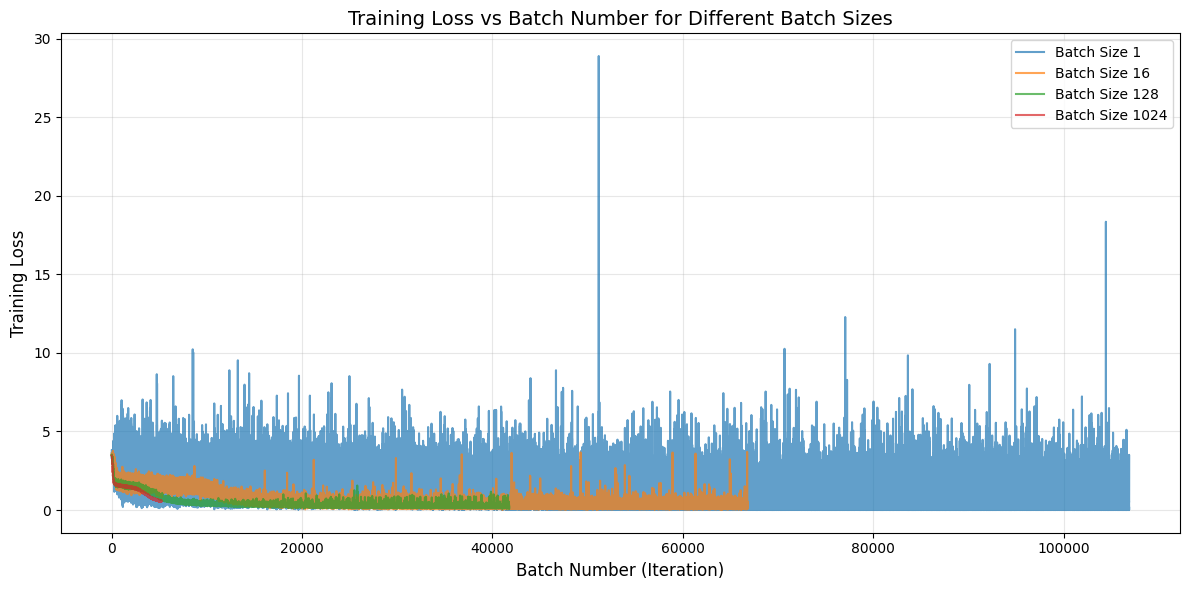

In [38]:
# Plot training loss vs batch number for part (iii)
plt.figure(figsize=(12, 6))
for idx, (batch_size, epochs) in enumerate(iterations_list):
    # Use markers for single point (batch_size=1, epochs=1)
    if len(all_batch_losses[idx]) == 1:
        plt.plot(all_batch_losses[idx], 'o', markersize=10, label=f'Batch Size {batch_size}', alpha=0.8)
    else:
        plt.plot(all_batch_losses[idx], label=f'Batch Size {batch_size}', alpha=0.7, linewidth=1.5)
plt.xlabel('Batch Number (Iteration)', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss vs Batch Number for Different Batch Sizes', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resultsMLP/training_loss_vs_batch.png', dpi=150)
plt.show()


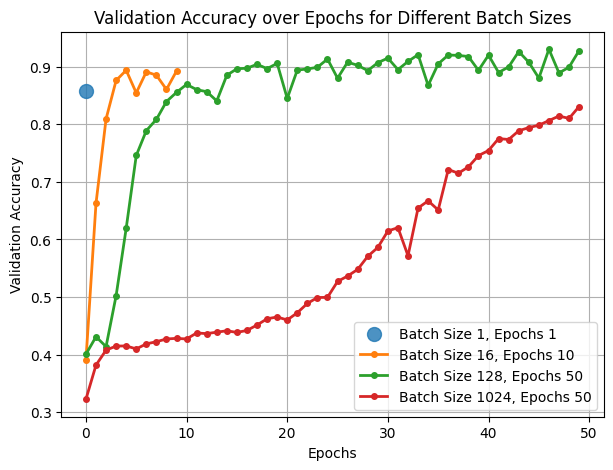

In [42]:
batch_sizes = [bs for bs, _ in iterations_list]
plt.figure(figsize=(7,5))
for idx, (bs, ep) in enumerate(iterations_list):  # Fixed: added parentheses around (bs, ep)
    # Handle single point with marker
    if len(validation_accuracies[idx]) == 1:  # Fixed: check validation_accuracies[idx] not val_losses
        plt.plot(validation_accuracies[idx], 'o', markersize=10, label=f"Batch Size {bs}, Epochs {ep}", alpha=0.8)
    else:
        plt.plot(validation_accuracies[idx], marker='o', label=f"Batch Size {bs}, Epochs {ep}", linewidth=2, markersize=4)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.savefig(f"resultsMLP/all_batchsize_epochs_val_accuracies.png")
plt.show()


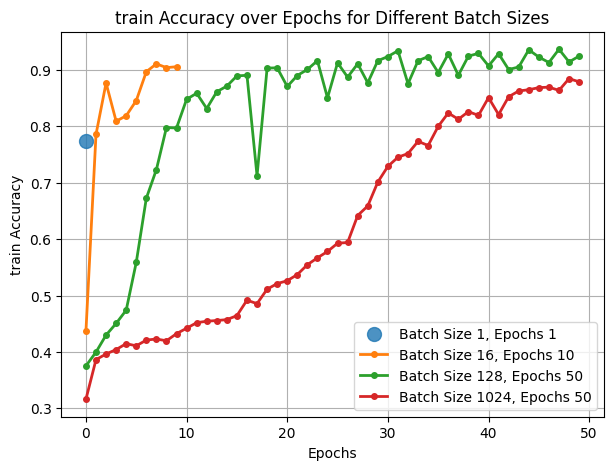

In [44]:
batch_sizes = [bs for bs, _ in iterations_list]
plt.figure(figsize=(7,5))
for idx, (bs, ep) in enumerate(iterations_list):  # Fixed: added parentheses around (bs, ep)
    # Handle single point with marker
    if len(validation_accuracies[idx]) == 1:  # Fixed: check validation_accuracies[idx] not val_losses
        plt.plot(train_accuracies[idx], 'o', markersize=10, label=f"Batch Size {bs}, Epochs {ep}", alpha=0.8)
    else:
        plt.plot(train_accuracies[idx], marker='o', label=f"Batch Size {bs}, Epochs {ep}", linewidth=2, markersize=4)
plt.xlabel('Epochs')
plt.ylabel('train Accuracy')
plt.title('train Accuracy over Epochs for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.savefig(f"resultsMLP/all_batchsize_epochs_train_accuracies.png")
plt.show()

Epoch 0, Train Acc: 0.341, Val Acc: 0.341, Test Acc: 0.340
Epoch 1, Train Acc: 0.369, Val Acc: 0.368, Test Acc: 0.368
Epoch 2, Train Acc: 0.380, Val Acc: 0.379, Test Acc: 0.379
Epoch 3, Train Acc: 0.382, Val Acc: 0.384, Test Acc: 0.382
Epoch 4, Train Acc: 0.398, Val Acc: 0.399, Test Acc: 0.399
Epoch 5, Train Acc: 0.409, Val Acc: 0.411, Test Acc: 0.411
Epoch 6, Train Acc: 0.437, Val Acc: 0.436, Test Acc: 0.440
Epoch 7, Train Acc: 0.443, Val Acc: 0.447, Test Acc: 0.441
Epoch 8, Train Acc: 0.446, Val Acc: 0.448, Test Acc: 0.447
Epoch 9, Train Acc: 0.459, Val Acc: 0.462, Test Acc: 0.462
Epoch 10, Train Acc: 0.478, Val Acc: 0.480, Test Acc: 0.476
Epoch 11, Train Acc: 0.493, Val Acc: 0.496, Test Acc: 0.495
Epoch 12, Train Acc: 0.505, Val Acc: 0.511, Test Acc: 0.507
Epoch 13, Train Acc: 0.515, Val Acc: 0.523, Test Acc: 0.518
Epoch 14, Train Acc: 0.525, Val Acc: 0.528, Test Acc: 0.526
Epoch 15, Train Acc: 0.551, Val Acc: 0.556, Test Acc: 0.552
Epoch 16, Train Acc: 0.604, Val Acc: 0.608, Test A

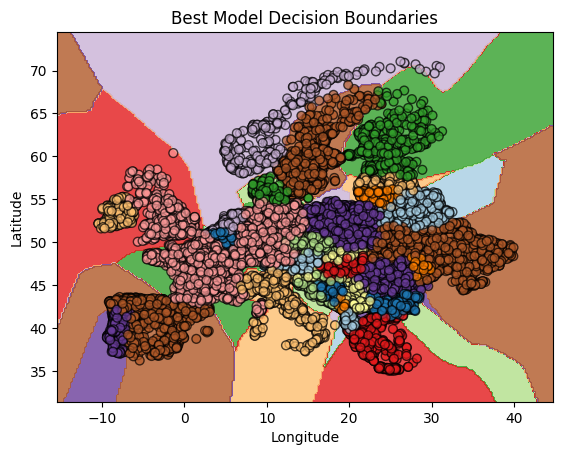

The best modele with arichetecture of (6, 64), validation loss of 0.1214283714927457, and test accuracy of 0.8979271121754097


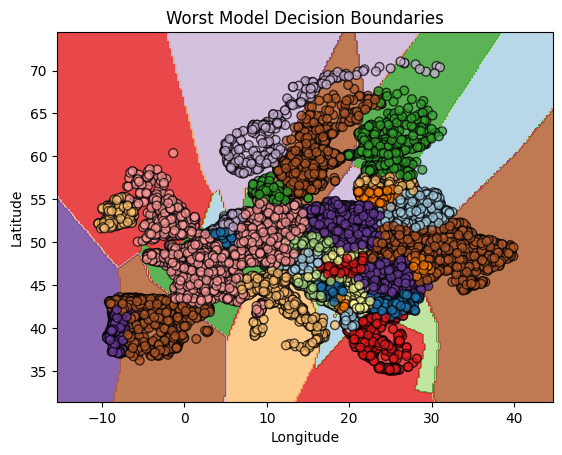

The worst modele with arichetecture of (1, 16), validation loss of 0.6467891985460339, and test accuracy of 0.7875477063533638


In [21]:
iterations_list = [(1,16),(2,16),(6,16),(10,16),(6,8),(6,32),(6,64)]
validation_accuracies = []
train_accuracies = []
all_batch_losses = [] 
best_model_dict = None
worst_model_dict = None
best_model_validation_loss= np.inf
worst_model_validation_loss = -np.inf
best_model_arch = None  # Track architecture (depth, width)
worst_model_arch = None
iteration_best_accuracies_train = {key:None for key in iterations_list}  
iteration_best_accuracies_test = {key:None for key in iterations_list}   
iteration_best_accuracies_val = {key:None for key in iterations_list}  
for depth, width in iterations_list:
    model = MLP(depth, width, output_dim, with_batchnorm=False)
    model, train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, cur_model_dict, cur_best_loss_val, batch_losses, best_test_acc, best_train_acc, best_validation_acc = train(train_dataset, val_dataset, test_dataset, model, lr=0.001, epochs=50, batch_size=256)
    validation_accuracies.append(val_accs)
    train_accuracies.append(train_accs)
    all_batch_losses.append(batch_losses)  
    plot_and_save_results(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, f'depth_{depth}_width_{width}_mlp.png')
    if cur_best_loss_val < best_model_validation_loss:
        best_model_validation_loss = cur_best_loss_val
        best_model_dict = cur_model_dict
        best_model_arch = (depth, width)  # Save architecture
    if cur_best_loss_val > worst_model_validation_loss:
        worst_model_validation_loss = cur_best_loss_val
        worst_model_dict = cur_model_dict
        worst_model_arch = (depth, width)  # Save architecture
    iteration_best_accuracies_train[(depth,width)]= best_train_acc
    iteration_best_accuracies_test[(depth,width)]= best_test_acc
    iteration_best_accuracies_val[(depth,width)] = best_validation_acc
# Recreate best model with correct architecture
best_model = MLP(best_model_arch[0], best_model_arch[1], output_dim, with_batchnorm=False)
best_model.load_state_dict(best_model_dict)
plot_decision_boundaries(best_model, test_data[['long', 'lat']].values, test_data['country'].values, 'Best Model Decision Boundaries', implicit_repr=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0,pin_memory=False)
criterion = nn.CrossEntropyLoss()
best_test_loss,best_test_acc = measure_current_model_on_set(testloader, best_model, criterion)
print (f"The best modele with arichetecture of {best_model_arch}, validation loss of {best_model_validation_loss}, and test accuracy of {best_test_acc}")
# Recreate worst model with correct architecture
worst_model = MLP(worst_model_arch[0], worst_model_arch[1], output_dim, with_batchnorm=False)
worst_model.load_state_dict(worst_model_dict)
plot_decision_boundaries(worst_model, test_data[['long', 'lat']].values, test_data['country'].values, 'Worst Model Decision Boundaries', implicit_repr=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0,pin_memory=False)
worst_test_loss, worst_test_accuracy =measure_current_model_on_set(testloader, worst_model, criterion)
print (f"The worst modele with arichetecture of {worst_model_arch}, validation loss of {worst_model_validation_loss}, and test accuracy of {worst_test_accuracy}")

## Question 3: Depth of Network Analysis
Using only MLPs of width 16, plot training, validation and test accuracy vs. number of hidden layers.

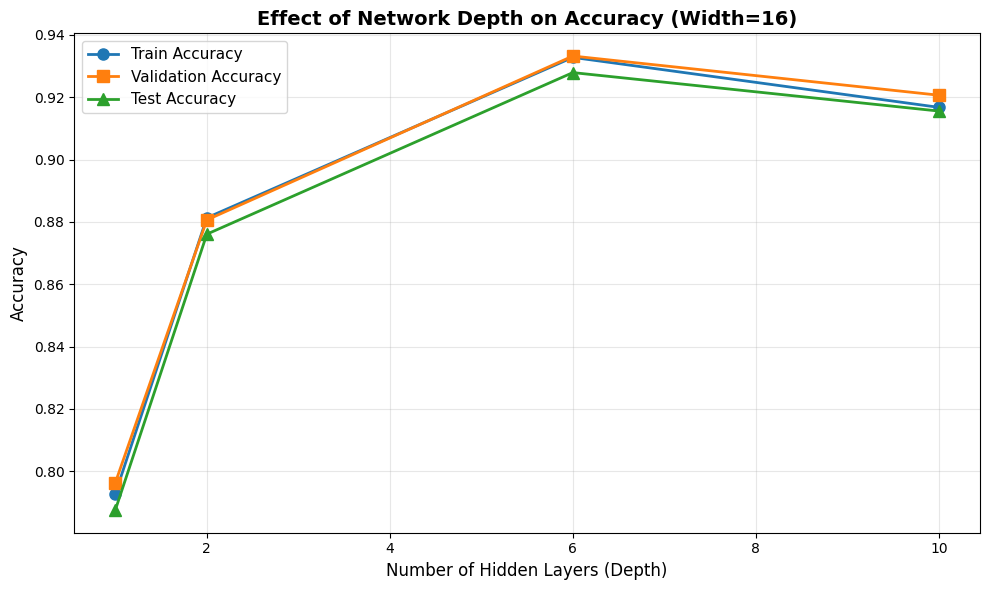

Depth Analysis (Width=16):
Depth 1: Train=0.7928, Val=0.7963, Test=0.7875
Depth 2: Train=0.8813, Val=0.8806, Test=0.8761
Depth 6: Train=0.9328, Val=0.9332, Test=0.9279
Depth 10: Train=0.9168, Val=0.9207, Test=0.9156


In [22]:
# Question 3: Depth of Network (Width = 16)
# Extract results for models with width=16
depth_experiments = [(1,16), (2,16), (6,16), (10,16)]
depths = [d for d, w in depth_experiments]

train_accs_depth = [iteration_best_accuracies_train[exp] for exp in depth_experiments]
val_accs_depth = [iteration_best_accuracies_val[exp] for exp in depth_experiments]
test_accs_depth = [iteration_best_accuracies_test[exp] for exp in depth_experiments]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accs_depth, marker='o', linewidth=2, markersize=8, label='Train Accuracy')
plt.plot(depths, val_accs_depth, marker='s', linewidth=2, markersize=8, label='Validation Accuracy')
plt.plot(depths, test_accs_depth, marker='^', linewidth=2, markersize=8, label='Test Accuracy')
plt.xlabel('Number of Hidden Layers (Depth)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effect of Network Depth on Accuracy (Width=16)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resultsMLP/depth_vs_accuracy_width16.png', dpi=150)
plt.show()

print("Depth Analysis (Width=16):")
for depth, train_acc, val_acc, test_acc in zip(depths, train_accs_depth, val_accs_depth, test_accs_depth):
    print(f"Depth {depth}: Train={train_acc:.4f}, Val={val_acc:.4f}, Test={test_acc:.4f}")

### Analysis: Why does depth 10 perform worse than depth 6?

**Vanishing/Exploding Gradients Problem:**

Without normalization techniques (like batch normalization) or residual connections, deeper networks suffer from:

1. **Vanishing Gradients**: As gradients backpropagate through many layers (10 hidden layers in this case), they get multiplied by weight matrices and activation derivatives repeatedly. With ReLU and standard initialization, gradients can become very small, making it difficult for early layers to learn effectively.

2. **Dying ReLUs**: In deeper networks, ReLU neurons can get stuck in the negative region and always output 0, preventing any gradient flow through them.

3. **Optimization Difficulty**: Deeper networks have more complex loss surfaces with more local minima, making optimization harder without proper techniques.

4. **No Skip Connections**: Unlike modern architectures (ResNet), our simple MLP lacks residual connections that allow gradients to flow directly to earlier layers.

**Solutions that would help:**
- Batch normalization (which we test separately)
- Residual/skip connections
- Better initialization (e.g., He initialization for ReLU)
- Gradient clipping
- Different activation functions (e.g., LeakyReLU, ELU)

## Question 4: Width of Network Analysis
Using only MLPs of depth 6, plot training, validation and test accuracy vs. number of neurons in each hidden layer.

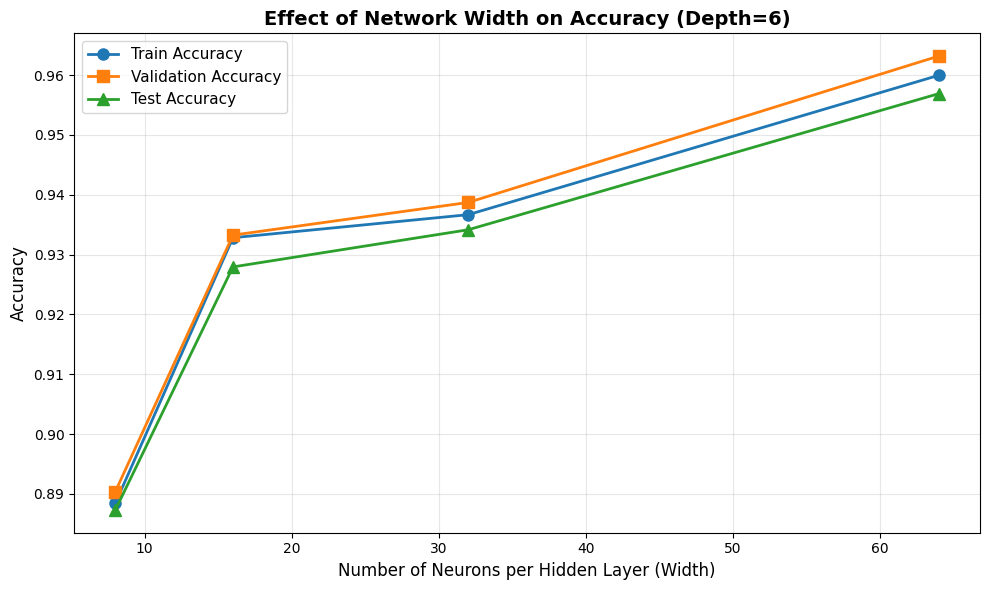

Width Analysis (Depth=6):
Width 8: Train=0.8884, Val=0.8904, Test=0.8873
Width 16: Train=0.9328, Val=0.9332, Test=0.9279
Width 32: Train=0.9367, Val=0.9387, Test=0.9341
Width 64: Train=0.9600, Val=0.9632, Test=0.9569


In [23]:
# Question 4: Width of Network (Depth = 6)
# Extract results for models with depth=6
width_experiments = [(6,8), (6,16), (6,32), (6,64)]
widths = [w for d, w in width_experiments]

train_accs_width = [iteration_best_accuracies_train[exp] for exp in width_experiments]
val_accs_width = [iteration_best_accuracies_val[exp] for exp in width_experiments]
test_accs_width = [iteration_best_accuracies_test[exp] for exp in width_experiments]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(widths, train_accs_width, marker='o', linewidth=2, markersize=8, label='Train Accuracy')
plt.plot(widths, val_accs_width, marker='s', linewidth=2, markersize=8, label='Validation Accuracy')
plt.plot(widths, test_accs_width, marker='^', linewidth=2, markersize=8, label='Test Accuracy')
plt.xlabel('Number of Neurons per Hidden Layer (Width)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effect of Network Width on Accuracy (Depth=6)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resultsMLP/width_vs_accuracy_depth6.png', dpi=150)
plt.show()

print("Width Analysis (Depth=6):")
for width, train_acc, val_acc, test_acc in zip(widths, train_accs_width, val_accs_width, test_accs_width):
    print(f"Width {width}: Train={train_acc:.4f}, Val={val_acc:.4f}, Test={test_acc:.4f}")

## Question 5: Monitoring Gradients

Train a model with 100 hidden layers, each with 4 neurons. Track the magnitude of gradients for each layer through training and analyze vanishing/exploding gradient problems.

In [30]:
def train_with_gradient_tracking(train_dataset, model, lr=0.001, epochs=10, batch_size=256):
    """
    Train a model while tracking gradient magnitudes for each layer.
    Returns gradient magnitudes averaged per epoch for each layer.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                              num_workers=0, pin_memory=False, drop_last=True)
    
    # Store gradient magnitudes: epochs x layers
    # We need to identify which parameters belong to which layer
    layer_params = []
    layer_names = []
    for i, module in enumerate(model.model):
        if isinstance(module, nn.Linear):
            layer_params.append(list(module.parameters()))
            layer_names.append(f"Linear_{len(layer_params)-1}")
    
    print(f"Found {len(layer_params)} linear layers in the model")
    
    num_layers = len(layer_params)
    gradient_magnitudes = {layer_idx: [] for layer_idx in range(num_layers)}
    
    for ep in range(epochs):
        model.train()
        epoch_gradients = {layer_idx: [] for layer_idx in range(num_layers)}
        batch_count = 0
        
        for batch_X, batch_y in trainloader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            
            # Collect gradient magnitudes for each layer (L2 norm squared)
            for layer_idx, params in enumerate(layer_params):
                layer_grad_mag = 0.0
                for param in params:
                    if param.grad is not None:
                        layer_grad_mag += (param.grad ** 2).sum().item()
                    else:
                        print(f"WARNING: Layer {layer_idx} has None gradient!")
                # grad_magnitude = ||grad||₂² (norm squared, as per problem statement)
                epoch_gradients[layer_idx].append(layer_grad_mag)
            
            batch_count += 1
            optimizer.step()
        
        # Average gradients over all batches in this epoch
        for layer_idx in range(num_layers):
            if len(epoch_gradients[layer_idx]) > 0:
                avg_grad = np.mean(epoch_gradients[layer_idx])
                gradient_magnitudes[layer_idx].append(avg_grad)
            else:
                print(f"WARNING: No gradients collected for layer {layer_idx} in epoch {ep}")
                gradient_magnitudes[layer_idx].append(0.0)
        
        # Print detailed gradients from different layers for debugging
        if ep == 0 or ep == epochs - 1:  # First and last epoch
            print(f'\nEpoch {ep+1}/{epochs} - Processed {batch_count} batches:')
            for sample_layer in [0, 50, 99]:
                print(f'  Layer {sample_layer:3d}: {gradient_magnitudes[sample_layer][ep]:.10e}')
        else:
            print(f'Epoch {ep+1}/{epochs} completed ({batch_count} batches)')
    
    return gradient_magnitudes

In [31]:
# Create a very deep network: 100 hidden layers with 4 neurons each
torch.manual_seed(0)
np.random.seed(0)
deep_model = MLP(num_hidden_layers=100, hidden_dim=4, output_dim=output_dim, with_batchnorm=False)

print(f"Created model with 100 hidden layers, 4 neurons each")
print(f"Total parameters: {sum(p.numel() for p in deep_model.parameters())}")

# Train and track gradients
gradient_magnitudes = train_with_gradient_tracking(train_dataset, deep_model, lr=0.001, epochs=10, batch_size=256)

Created model with 100 hidden layers, 4 neurons each
Total parameters: 2157
Found 101 linear layers in the model

Epoch 1/10 - Processed 417 batches:
  Layer   0: 0.0000000000e+00
  Layer  50: 0.0000000000e+00
  Layer  99: 2.7284834885e-03
Epoch 2/10 completed (417 batches)
Epoch 3/10 completed (417 batches)
Epoch 4/10 completed (417 batches)
Epoch 5/10 completed (417 batches)
Epoch 6/10 completed (417 batches)
Epoch 7/10 completed (417 batches)
Epoch 8/10 completed (417 batches)
Epoch 9/10 completed (417 batches)

Epoch 10/10 - Processed 417 batches:
  Layer   0: 0.0000000000e+00
  Layer  50: 0.0000000000e+00
  Layer  99: 9.1662972734e-04


In [33]:
# Sanity check: manually compute gradients for first batch to verify
print("\n=== Sanity Check: First Batch Gradients ===")
torch.manual_seed(0)
test_model = MLP(num_hidden_layers=100, hidden_dim=4, output_dim=output_dim, with_batchnorm=False)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)
criterion = nn.CrossEntropyLoss()

# Get first batch
batch_X, batch_y = next(iter(test_loader))

# Forward and backward
test_model.train()
predictions = test_model(batch_X)
loss = criterion(predictions, batch_y)
loss.backward()

# Check gradients for a few layers
linear_layers = [m for m in test_model.model if isinstance(m, nn.Linear)]
print(f"Number of linear layers: {len(linear_layers)}")
for idx in [0, 50, 99, 100]:  # 100 is the output layer
    if idx < len(linear_layers):
        layer = linear_layers[idx]
        weight_grad_norm_sq = (layer.weight.grad ** 2).sum().item()
        bias_grad_norm_sq = (layer.bias.grad ** 2).sum().item() if layer.bias is not None else 0
        total = weight_grad_norm_sq + bias_grad_norm_sq
        print(f"Layer {idx}: Weight grad ||²={weight_grad_norm_sq:.10e}, Bias grad ||²={bias_grad_norm_sq:.10e}, Total={total:.10e}")

print("\n" + "="*70)


=== Sanity Check: First Batch Gradients ===
Number of linear layers: 101
Layer 0: Weight grad ||²=0.0000000000e+00, Bias grad ||²=0.0000000000e+00, Total=0.0000000000e+00
Layer 50: Weight grad ||²=0.0000000000e+00, Bias grad ||²=0.0000000000e+00, Total=0.0000000000e+00
Layer 99: Weight grad ||²=0.0000000000e+00, Bias grad ||²=9.2327417806e-03, Total=9.2327417806e-03
Layer 100: Weight grad ||²=4.8290868290e-03, Bias grad ||²=1.9036410376e-02, Total=2.3865497205e-02



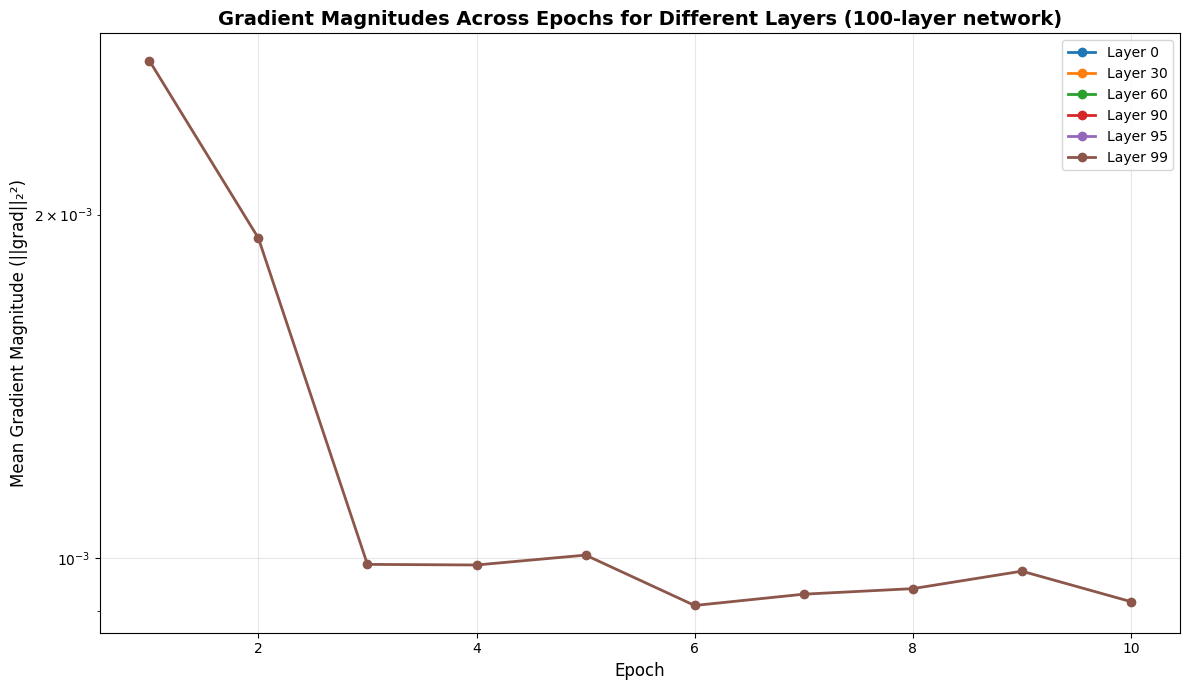


Gradient Magnitude Statistics (||grad||₂²):
Layer  0: First epoch = 0.0000000000e+00, Last epoch = 0.0000000000e+00, Mean = 0.0000000000e+00
Layer 30: First epoch = 0.0000000000e+00, Last epoch = 0.0000000000e+00, Mean = 0.0000000000e+00
Layer 60: First epoch = 0.0000000000e+00, Last epoch = 0.0000000000e+00, Mean = 0.0000000000e+00
Layer 90: First epoch = 0.0000000000e+00, Last epoch = 0.0000000000e+00, Mean = 0.0000000000e+00
Layer 95: First epoch = 0.0000000000e+00, Last epoch = 0.0000000000e+00, Mean = 0.0000000000e+00
Layer 99: First epoch = 2.7284834885e-03, Last epoch = 9.1662972734e-04, Mean = 1.2290368873e-03

Gradient Ratio (Layer 0 / Layer 99):
Epoch 1: 0.00e+00
This shows how much gradients have vanished by the time they reach layer 0


In [35]:
# Plot gradient magnitudes for specific layers: 0, 30, 60, 90, 95, 99
layers_to_plot = [0, 30, 60, 90, 95, 99]
epochs_range = list(range(1, 11))

plt.figure(figsize=(12, 7))
for layer_idx in layers_to_plot:
    plt.plot(epochs_range, gradient_magnitudes[layer_idx], 
             marker='o', linewidth=2, markersize=6, label=f'Layer {layer_idx}')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Gradient Magnitude (||grad||₂²)', fontsize=12)
plt.title('Gradient Magnitudes Across Epochs for Different Layers (100-layer network)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Use log scale to see differences better
plt.tight_layout()
plt.savefig('resultsMLP/gradient_magnitudes_100layers.png', dpi=150)
plt.show()

# Print statistics
print("\nGradient Magnitude Statistics (||grad||₂²):")
print("="*60)
for layer_idx in layers_to_plot:
    grads = gradient_magnitudes[layer_idx]
    print(f"Layer {layer_idx:2d}: First epoch = {grads[0]:.10e}, Last epoch = {grads[-1]:.10e}, "
          f"Mean = {np.mean(grads):.10e}")

# Also print ratio to show vanishing
print("\n" + "="*60)
print("Gradient Ratio (Layer 0 / Layer 99):")
ratio = gradient_magnitudes[0][0] / gradient_magnitudes[99][0] if gradient_magnitudes[99][0] > 0 else 0
print(f"Epoch 1: {ratio:.2e}")
print("This shows how much gradients have vanished by the time they reach layer 0")

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, with_batchnorm=True):
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.with_batchnorm = with_batchnorm
        if with_batchnorm:
            self.bn = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.linear(x)
        if self.with_batchnorm:
            out = self.bn(out)
        out += residual  # The skip connection
        out = self.relu(out)
        return out

class MLPRESNET(nn.Module):
    def __init__(self, num_hidden_layers, hidden_dim, output_dim):
        super(MLPRESNET, self).__init__()
        """
        Args:
            num_hidden_layers (int): The number of hidden layers, in total you'll have an extra layer at the end, from hidden_dim to output_dim
            hidden_dim (int): The hidden layer dimension
            output_dim (int): The output dimension, should match the number of classes in the dataset
        """
        #### YOUR CODE HERE ####
        layers = []
        input_dim = 2  # since we have longitude and latitude as input features
        
        # 1. First Layer: Input (2) -> Hidden. 
        # Cannot be residual because dimensions change (2 vs hidden_dim)
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.ReLU())
        
        # 2. Middle Layers: Hidden -> Hidden. 
        # These are Residual Blocks
        for _ in range(num_hidden_layers - 1):
            layers.append(ResidualBlock(hidden_dim, with_batchnorm=True))
            
        # 3. Output Layer: Hidden -> Output
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

Created ResNet with 100 hidden layers
Found 101 linear layers in the model
Epoch 5/10 gradient tracking done
Epoch 10/10 gradient tracking done


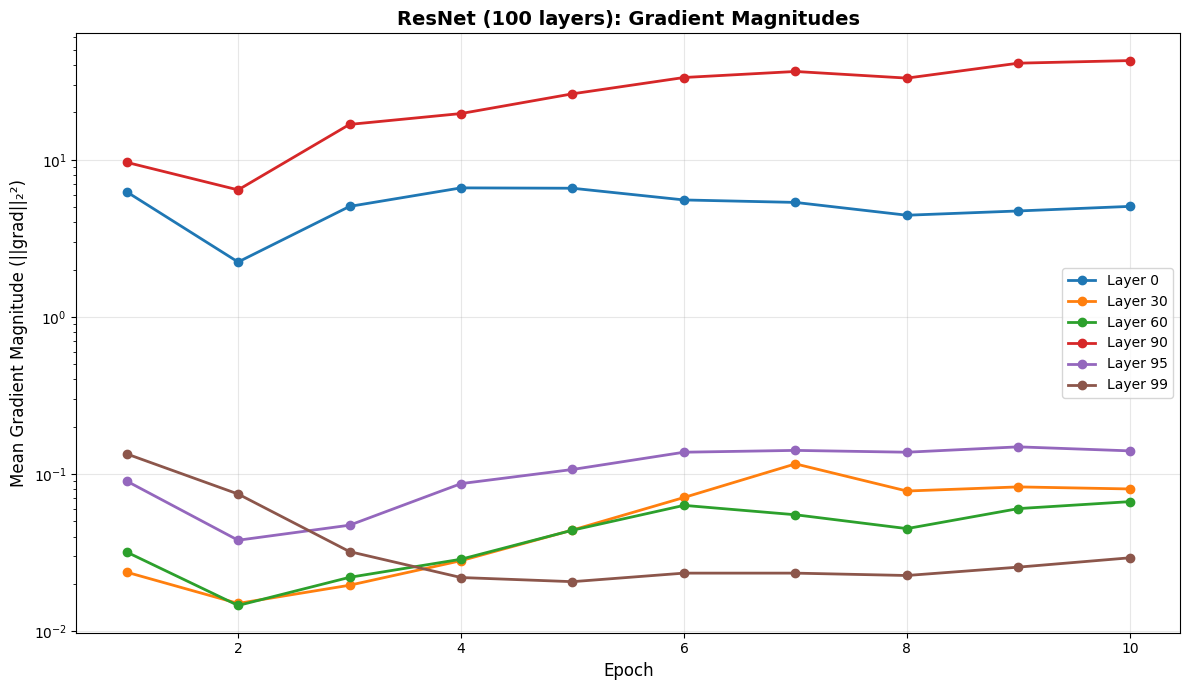


Gradient Ratio (Layer 0 / Layer 99):
Epoch 10: 1.72e+02


In [39]:
def train_resnet_with_gradient_tracking(train_dataset, model, lr=0.001, epochs=10, batch_size=256):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                              num_workers=0, pin_memory=False, drop_last=True)
    
    # Identify linear layers (recursively for ResNet)
    layer_params = []
    for module in model.modules():
        if isinstance(module, nn.Linear):
            layer_params.append(list(module.parameters()))
    
    print(f"Found {len(layer_params)} linear layers in the model")
    
    num_layers = len(layer_params)
    gradient_magnitudes = {layer_idx: [] for layer_idx in range(num_layers)}
    
    for ep in range(epochs):
        model.train()
        epoch_gradients = {layer_idx: [] for layer_idx in range(num_layers)}
        
        for batch_X, batch_y in trainloader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            
            for layer_idx, params in enumerate(layer_params):
                layer_grad_mag = 0.0
                for param in params:
                    if param.grad is not None:
                        layer_grad_mag += (param.grad ** 2).sum().item()
                epoch_gradients[layer_idx].append(layer_grad_mag)
            
            optimizer.step()
        
        for layer_idx in range(num_layers):
            if len(epoch_gradients[layer_idx]) > 0:
                gradient_magnitudes[layer_idx].append(np.mean(epoch_gradients[layer_idx]))
            else:
                gradient_magnitudes[layer_idx].append(0.0)
                
        if (ep+1) % 5 == 0:
            print(f"Epoch {ep+1}/{epochs} gradient tracking done")
            
    return gradient_magnitudes

# 1. Gradient Analysis
torch.manual_seed(0)
np.random.seed(0)

# Note: MLPRESNET forces batchnorm=True internally based on previous cell implementation
resnet_model_grads = MLPRESNET(num_hidden_layers=100, hidden_dim=4, output_dim=output_dim)
print(f"Created ResNet with 100 hidden layers")

resnet_grads = train_resnet_with_gradient_tracking(train_dataset, resnet_model_grads, lr=0.001, epochs=10)

# Plot
layers_to_plot = [0, 30, 60, 90, 95, 99]
epochs_range = list(range(1, 11))

plt.figure(figsize=(12, 7))
for layer_idx in layers_to_plot:
    plt.plot(epochs_range, resnet_grads[layer_idx], 
             marker='o', linewidth=2, markersize=6, label=f'Layer {layer_idx}')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Gradient Magnitude (||grad||₂²)', fontsize=12)
plt.title('ResNet (100 layers): Gradient Magnitudes', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.savefig('resultsMLP/resnet_gradients.png', dpi=150)
plt.show()

print("\nGradient Ratio (Layer 0 / Layer 99):")
# Check if gradients exist to avoid division by zero
if len(resnet_grads[99]) > 0 and resnet_grads[99][-1] > 0:
    ratio = resnet_grads[0][-1] / resnet_grads[99][-1]
    print(f"Epoch 10: {ratio:.2e}")
else:
    print("Epoch 10: N/A (Gradient is 0)")

In [40]:
# 2. Performance Analysis (Success Measurement)
torch.manual_seed(0)
np.random.seed(0)

resnet_model_train = MLPRESNET(num_hidden_layers=100, hidden_dim=4, output_dim=output_dim)

print("\nStarting Training of Deep ResNet...")
model, train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, _, best_loss_val, _, best_test_acc, _, _ = train(
    train_dataset, val_dataset, test_dataset, resnet_model_train, lr=0.001, epochs=50, batch_size=256
)

# Reuse previous plotting function
plot_and_save_results(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, 'resnet_100layers_performance.png')
print(f"Final Test Accuracy: {test_accs[-1]:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")


Starting Training of Deep ResNet...
Epoch 0, Train Acc: 0.257, Val Acc: 0.253, Test Acc: 0.253
Epoch 1, Train Acc: 0.344, Val Acc: 0.342, Test Acc: 0.344
Epoch 2, Train Acc: 0.422, Val Acc: 0.423, Test Acc: 0.422
Epoch 3, Train Acc: 0.446, Val Acc: 0.444, Test Acc: 0.442
Epoch 4, Train Acc: 0.442, Val Acc: 0.438, Test Acc: 0.446
Epoch 5, Train Acc: 0.476, Val Acc: 0.472, Test Acc: 0.475
Epoch 6, Train Acc: 0.573, Val Acc: 0.566, Test Acc: 0.571
Epoch 7, Train Acc: 0.558, Val Acc: 0.555, Test Acc: 0.553
Epoch 8, Train Acc: 0.555, Val Acc: 0.552, Test Acc: 0.554
Epoch 9, Train Acc: 0.605, Val Acc: 0.602, Test Acc: 0.602
Epoch 10, Train Acc: 0.610, Val Acc: 0.607, Test Acc: 0.606
Epoch 11, Train Acc: 0.658, Val Acc: 0.656, Test Acc: 0.657
Epoch 12, Train Acc: 0.688, Val Acc: 0.689, Test Acc: 0.691
Epoch 13, Train Acc: 0.657, Val Acc: 0.655, Test Acc: 0.659
Epoch 14, Train Acc: 0.684, Val Acc: 0.684, Test Acc: 0.682
Epoch 15, Train Acc: 0.706, Val Acc: 0.708, Test Acc: 0.707
Epoch 16, Tra